In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

path = './data/'
def get_ds_infos():
    ## 0:Code, 1:Weight, 2:Height, 3:Age, 4:Gender
    file = path + 'data_subjects_info.csv'
    dss = pd.read_csv(file, sep=',')
    print("Subjects data is imported.")
    return dss.get_values()

Load User information

In [26]:
act_numeric = {"dws":0, "ups":1, "wlk":2, "jog":3, "std":4, "sit":5}
trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16], "std":[6,14], "sit":[5,13]} 
ds_list = get_ds_infos()

Subjects data is imported.


Create df for all users and activity

In [27]:
all_data = []

for sub_id, gender, weight, height in zip(ds_list[:,0], ds_list[:,4], ds_list[:,1], ds_list[:,2]):
    for act in list(act_numeric.keys()):
        for trial in trial_codes[act]:
            
            directory = 'A_DeviceMotion_data/'
            fname = path + directory +act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
            motion = pd.read_csv(fname)
            motion = motion.drop(motion.columns[0], axis=1)
            '''
            directory = 'B_Accelerometer_data/'
            fname = path + directory +act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
            accelerometer = pd.read_csv(fname)
            accelerometer = accelerometer.drop(accelerometer.columns[0], axis=1)
            accelerometer.rename(columns=lambda x: 'accelerometer.' + x, inplace=True)
            
            directory = 'C_Gyroscope_data/'
            fname = path + directory +act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
            gyroscope = pd.read_csv(fname)
            gyroscope = gyroscope.drop(gyroscope.columns[0], axis=1)
            gyroscope.rename(columns=lambda x: 'gyroscope.' + x, inplace=True)
            
            '''
            raw_data = motion
            raw_data['act'] = act_numeric[act]
            raw_data['gender'] = gender
            raw_data['BMI'] = weight/(height*height)*10000
            all_data.append(raw_data)

Split all series for small snapshots

In [28]:
def split_ts(all_ts, act_labels, gen_labels=None, bmi_labels=None, slide_size=200, step=20, flat=False, verbose=False, tranpose=False):
    split_ts = []
    act_split_labels = []
    gen_split_labels = []
    bmi_split_labels = []
    for (ts, act, gen, bmi) in zip(all_ts, act_labels, gen_labels, bmi_labels):
        ts_size = len(ts)
        i = 0
        j = i+slide_size
        num_sect = 0 
        while j < ts_size-1:
            if flat:
                section = ts[i:j].flatten()
            else:
                section = ts[i:j]
            if tranpose:
                section = section.T
            split_ts.append(section)
            act_split_labels.append(act)
            gen_split_labels.append(gen)
            bmi_split_labels.append(bmi)
            i += step
            j += step
            num_sect += 1

        if verbose:
            print('label = %s len = %i' % (label, ts_size))
            print('num sect = %i' % (num_sect))
    return split_ts, act_split_labels, gen_split_labels, bmi_split_labels

In [29]:
data = []
act_target = []
gen_target = []
bmi_target = []

for i, i_data in enumerate(all_data):
    data.append(i_data.get_values()[:,:12])
    act_target.append(i_data['act'][0])
    gen_target.append(i_data['gender'][0]) 
    bmi_target.append(i_data['BMI'][0])

In [30]:
ts, act, gen, bmi = split_ts(data, act_target, gen_target, bmi_target, flat=False, tranpose=True)

Shuffle all data (doesn't work)

In [7]:
idx = np.random.permutation(len(ts))
ts_data  = ts[idx]
act_labels = act[idx] 
gen_labels = gen[idx] 
bmi_labels = bmi[idx]

TypeError: only integer scalar arrays can be converted to a scalar index

### Build networks

Prepare data

In [31]:
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten  
from keras.utils import np_utils, to_categorical, plot_model


In [9]:
train_data = np.array(ts[:60000])
test_data = np.array(ts[60000:])
categ_act_labels = to_categorical(act, num_classes=6)
train_act_labels = np.array(categ_act_labels[:60000])
test_act_labels = np.array(categ_act_labels[60000:])

BMI_value = ['Underweight', 'Normal', 'Overweight', 'Moderately obese']
bound = np.array([18.5, 25, 30])
bmi_buck = bound.searchsorted(np.array(bmi))
categ_bmi_labels = to_categorical(bmi_buck, num_classes=4)
train_bmi_labels = np.array(categ_bmi_labels[:60000])
test_bmi_labels = np.array(categ_bmi_labels[60000:])

In [9]:
train_data.shape

(60000, 12, 200)

#### MLP (4)

*If already save -- Load model*

In [32]:
json_file = open("act_model_3_mlp.json" , "r")
json_act_model = json_file.read()
json_file.close()

act_loss_func = "categorical_crossentropy"
metrics = ['acc']

act_mlp_model = model_from_json(json_act_model)
act_mlp_model.compile(loss=act_loss_func, optimizer='adam', metrics=metrics)

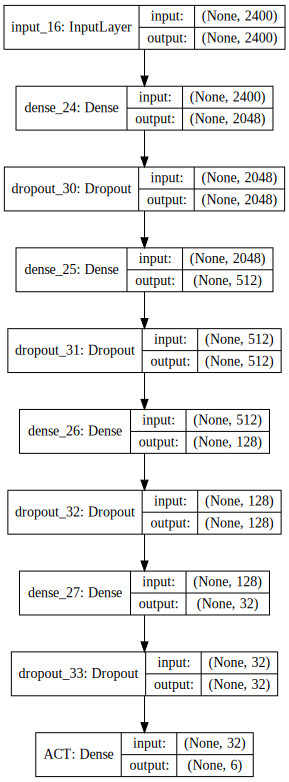

In [33]:
SVG(model_to_dot(act_mlp_model, show_shapes=True).create(prog='dot', format='svg', ))

In [91]:
num_train, inp_size = train_data.shape

hl_1 = 2048
hl_2 = 512
hl_3 = 128
hl_4 = 32

act_activation_func = 'softmax'
drop_prob_1 = 0.3
drop_prob_2 = 0.2
act_out_dim = len(np.unique(act_target))
batch_size=64

inp = Input(shape=(inp_size,)) 
dense_1 = Dense(hl_1, activation='relu')(inp)
drop_1 = Dropout(drop_prob_1)(dense_1)

dense_2 = Dense(hl_2, activation='relu')(drop_1)
drop_2 = Dropout(drop_prob_2)(dense_2)

dense_3 = Dense(hl_3, activation='relu')(drop_2)
drop_3 = Dropout(drop_prob_2)(dense_3)

dense_4 = Dense(hl_4, activation='relu')(drop_3)
drop_4 = Dropout(drop_prob_2)(dense_4)

out1 = Dense(act_out_dim, activation=act_activation_func, name="ACT")(drop_4)


Learn MLP w/ transpose (batch=64)

In [92]:
num_of_epochs = 20
verbosity = 1

act_loss_func = "categorical_crossentropy"
metrics = ['acc']
act_mlp_model = Model(inputs=inp, outputs=out1) 

act_mlp_model.compile(loss=act_loss_func, optimizer='adam', metrics=metrics)

In [93]:
history_mlp = act_mlp_model.fit(train_data, train_act_labels,                
                        epochs = num_of_epochs,
                        verbose = verbosity,
                        batch_size=batch_size) 

Epoch 1/20
60000/60000 [==============================] - 268s 4ms/step - loss: 0.4474 - acc: 0.8555
Epoch 2/20
60000/60000 [==============================] - 197s 3ms/step - loss: 0.2004 - acc: 0.9430
Epoch 3/20
60000/60000 [==============================] - 235s 4ms/step - loss: 0.1530 - acc: 0.9557
Epoch 4/20
60000/60000 [==============================] - 222s 4ms/step - loss: 0.1337 - acc: 0.9606
Epoch 5/20
60000/60000 [==============================] - 236s 4ms/step - loss: 0.1052 - acc: 0.9671
Epoch 6/20
60000/60000 [==============================] - 189s 3ms/step - loss: 0.0997 - acc: 0.9696
Epoch 7/20
60000/60000 [==============================] - 192s 3ms/step - loss: 0.0836 - acc: 0.9740
Epoch 8/20
60000/60000 [==============================] - 181s 3ms/step - loss: 0.1181 - acc: 0.9680
Epoch 9/20
60000/60000 [==============================] - 217s 4ms/step - loss: 0.0768 - acc: 0.9760
Epoch 10/20
60000/60000 [==============================] - 239s 4ms/step - loss: 0.0705 - a

In [94]:
plot_model(act_mlp_model, to_file='act_mlp.png', show_shapes=True)

predict_act_mlp_labels = act_mlp_model.predict(test_data, verbose=verbosity)

predict_act_mlp_labels = np.argmax(predict_act_mlp_labels, axis=1)

print(classification_report(act[60000:], predict_act_mlp_labels))

print(confusion_matrix(act[60000:], predict_act_mlp_labels))

print(accuracy_score(act[60000:], predict_act_mlp_labels))

act_model_json = act_mlp_model.to_json()
with open("act_model_3_mlp.json", "w") as json_file:
    json_file.write(act_model_json)
    
act_mlp_model.save_weights("act_weights_3_mlp.h5")

7205/7205 [==============================] - 13s 2ms/step
             precision    recall  f1-score   support

          0       0.95      0.87      0.91       430
          1       0.94      0.97      0.96       592
          2       0.99      0.99      0.99      1922
          3       0.95      0.99      0.97       737
          4       1.00      0.99      1.00      1819
          5       1.00      1.00      1.00      1705

avg / total       0.99      0.99      0.99      7205

[[ 376   12    5   37    0    0]
 [   7  577    8    0    0    0]
 [   3   15 1904    0    0    0]
 [   0    7    0  730    0    0]
 [   9    3    1    0 1806    0]
 [   0    0    0    0    0 1705]]
0.985149201943


old saving

In [ ]:
act_model_json = act_model.to_json()
with open("act_model_2_mlp.json", "w") as json_file:
    json_file.write(act_model_json)

In [ ]:
predict_act_labels = act_model.predict(test_data, verbose=verbosity)

predict_act_labels = np.argmax(predict_act_labels, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(act[60000:], predict_act_labels))

print(confusion_matrix(act[60000:], predict_act_labels))

peace of sht

Open from JSON

In [4]:
json_file = open("act_model_2_mlp.json" , "r")
json_act_model = json_file.read()
json_file.close()

act_loss_func = "categorical_crossentropy"
metrics = ['acc']

new_act_model = model_from_json(json_act_model)
new_act_model.compile(loss=act_loss_func, optimizer='adam', metrics=metrics)
plot_model(new_act_model, show_shapes=True)

inline plot

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(act_lstm_model).create(prog='dot', format='svg'))

Try tb plt (not work)

In [ ]:
from keras.callbacks import TensorBoard

tb = TensorBoard(log_dir='./logs/cnn-bmi/18.04.2018/', histogram_freq=5, write_graph=True)

history = act_model.fit(train_data, train_act_labels,                
                        epochs = num_of_epochs,
                        verbose = verbosity,
                       callback=[tb]) 


BMI in CNN

### CNN

*If already save -- Load model*

In [10]:
json_file = open("act_model_2_cnn.json" , "r")
json_act_model = json_file.read()
json_file.close()

act_loss_func = "categorical_crossentropy"
metrics = ['acc']

act_cnn_model = model_from_json(json_act_model)
act_cnn_model.compile(loss=act_loss_func, optimizer='adam', metrics=metrics)
#plot_model(act_cnn_model_model, to_file='act_cnn_2.png', show_shapes=True)

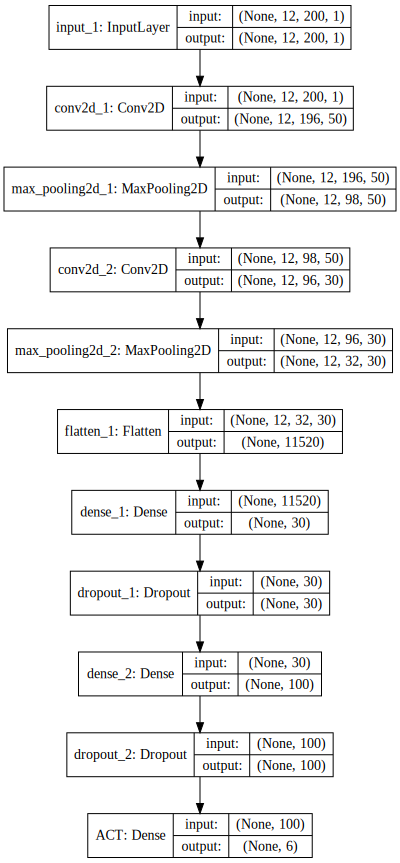

In [13]:
SVG(model_to_dot(act_cnn_model, show_shapes=True).create(prog='dot', format='svg'))

Expand dim for CNN

In [18]:
train_data = np.expand_dims(train_data,axis=3)
test_data = np.expand_dims(test_data,axis=3)

In [11]:
train_data.shape

(60000, 12, 200, 1)

In [12]:
num_train, height, width, channel = train_data.shape

act_activation_func = 'softmax'
bmi_activation_func = 'softmax'

drop_prob_1 = 0.3
drop_prob_2 = 0.2

act_out_dim = len(np.unique(act_target))
bmi_out_dim = len(np.unique(bmi_buck))

conv_depth_1 = 50 
conv_depth_2 = 30 
#conv_depth_3 = 20 

kernel_size_1 = 5
kernel_size_2 = 3
pool_size_1 = 2
pool_size_2 = 3  

batch_size = 64

hidden_size_1 = 100
#hidden_size_2 = 25

inp = Input(shape=(height, width,1))

conv_0 = Convolution2D(filters=conv_depth_1, kernel_size=(1, kernel_size_1), padding="valid", activation="relu")(inp)
#dense_1 = Dense(conv_depth_1, activation='relu')(conv_0)
pool_1 = MaxPooling2D(pool_size=(1, pool_size_1))(conv_0)
#drop_1 = Dropout(drop_prob_1)(pool_1)

conv_1 = Convolution2D(filters=conv_depth_2, kernel_size=(1, kernel_size_2), padding="valid", activation="relu")(pool_1)
#conv_2 = Convolution2D(filters=conv_depth_2, kernel_size=(1, kernel_size_2), padding="same", activation="relu")(conv_1)

pool_2 = MaxPooling2D(pool_size=(1, pool_size_2))(conv_1)

flat = Flatten()(pool_2)

dense_2 = Dense(conv_depth_2, activation='relu')(flat)
drop_2 = Dropout(drop_prob_2)(dense_2)


hidden_1 = Dense(hidden_size_1, activation='relu')(drop_2)
drop_3 = Dropout(drop_prob_2)(hidden_1)


out1 = Dense(act_out_dim, activation=act_activation_func, name = "ACT")(drop_3)


In [13]:
num_of_epochs = 20
verbosity = 1

act_loss_func = "categorical_crossentropy"
bmi_loss_func = "categorical_crossentropy"
metrics = ['acc']
act_cnn_model = Model(inputs=inp, outputs=out1) 
#bmi_model = Model(inputs=inp, outputs=out1) 
act_cnn_model.compile(loss=act_loss_func, optimizer='adam', metrics=metrics)

#bmi_model.compile(loss=bmi_loss_func, optimizer='adam', metrics=metrics)


In [14]:
#from keras.callbacks import TensorBoard

#tb = TensorBoard(log_dir='./logs/cnn-act/18.04.2018/', histogram_freq=5, write_graph=True, write_images=True)
history = act_cnn_model.fit(train_data, train_act_labels,                
                        epochs = num_of_epochs,
                        verbose = verbosity,
                        batch_size=batch_size)
                        #validation_data=(test_data, test_act_labels),
                        #callbacks=[tb]) 

Epoch 1/20
60000/60000 [==============================] - 49s 813us/step - loss: 0.2353 - acc: 0.9172
Epoch 2/20
60000/60000 [==============================] - 26s 441us/step - loss: 0.1043 - acc: 0.9680
Epoch 3/20
60000/60000 [==============================] - 26s 440us/step - loss: 0.0802 - acc: 0.9765
Epoch 4/20
60000/60000 [==============================] - 28s 470us/step - loss: 0.0652 - acc: 0.9802
Epoch 5/20
60000/60000 [==============================] - 27s 456us/step - loss: 0.0585 - acc: 0.9817
Epoch 6/20
60000/60000 [==============================] - 26s 436us/step - loss: 0.0495 - acc: 0.9833
Epoch 7/20
60000/60000 [==============================] - 28s 463us/step - loss: 0.0444 - acc: 0.9853
Epoch 8/20
60000/60000 [==============================] - 27s 452us/step - loss: 0.0412 - acc: 0.9860
Epoch 9/20
60000/60000 [==============================] - 27s 452us/step - loss: 0.0373 - acc: 0.9878
Epoch 10/20
60000/60000 [==============================] - 28s 459us/step - loss: 

plot_model(act_model, to_file='act_cnn.png', show_shapes=True)

In [14]:
plot_model(act_cnn_model, to_file='act_cnn_2.png', show_shapes=True)

In [15]:
act_cnn_model.load_weights("act_weights_2_cnn.h5")

In [19]:
verbosity=1
predict_act_labels = act_cnn_model.predict(test_data, verbose=verbosity)

predict_act_labels = np.argmax(predict_act_labels, axis=1)

7205/7205 [==============================] - 13s 2ms/step


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(act[60000:], predict_act_labels))

print(confusion_matrix(act[60000:], predict_act_labels))

             precision    recall  f1-score   support

          0       0.96      0.86      0.91       430
          1       0.55      1.00      0.71       592
          2       1.00      0.77      0.87      1922
          3       0.99      0.99      0.99       737
          4       1.00      1.00      1.00      1819
          5       1.00      1.00      1.00      1705

avg / total       0.96      0.93      0.93      7205

[[ 371   56    3    0    0    0]
 [   0  591    1    0    0    0]
 [  10  417 1485   10    0    0]
 [   4    1    0  732    0    0]
 [   0    0    0    0 1811    8]
 [   0    0    0    0    0 1705]]


In [21]:
from sklearn.metrics import accuracy_score
print(accuracy_score(act[60000:], predict_act_labels))

0.929215822346


In [20]:
act_model_json = act_cnn_model.to_json()
with open("act_model_2_cnn.json", "w") as json_file:
    json_file.write(act_model_json)
    
act_cnn_model.save_weights("act_weights_2_cnn.h5")

### LSTM

*If already save -- Load model*

In [34]:
json_file = open("act_model_1_lstm.json" , "r")
json_act_model = json_file.read()
json_file.close()

act_loss_func = "categorical_crossentropy"
metrics = ['acc']

act_lstm_model = model_from_json(json_act_model)
act_lstm_model.compile(loss=act_loss_func, optimizer='adam', metrics=metrics)

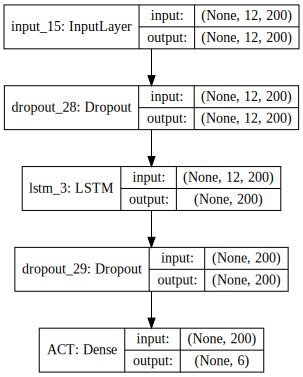

In [35]:
SVG(model_to_dot(act_lstm_model, show_shapes=True).create(prog='dot', format='svg'))

In [65]:
from keras.layers import LSTM, Embedding

In [75]:
ts, act, gen, bmi = split_ts(data, act_target, gen_target, bmi_target, flat=False, tranpose=True)

In [76]:
train_data = np.array(ts[:60000])
test_data = np.array(ts[60000:])
categ_act_labels = to_categorical(act, num_classes=6)
train_act_labels = np.array(categ_act_labels[:60000])
test_act_labels = np.array(categ_act_labels[60000:])

BMI_value = ['Underweight', 'Normal', 'Overweight', 'Moderately obese']
bound = np.array([18.5, 25, 30])
bmi_buck = bound.searchsorted(np.array(bmi))
categ_bmi_labels = to_categorical(bmi_buck, num_classes=4)
train_bmi_labels = np.array(categ_bmi_labels[:60000])
test_bmi_labels = np.array(categ_bmi_labels[60000:])

In [79]:
num_train, size, timestaps = train_data.shape

embed_dim = 128
lstm_out = 200
batch_size = 32
drop_prob_1 = 0.2
act_out_dim = len(np.unique(act_target))
act_activation_func = 'softmax'

inp = Input(shape=(size,timestaps)) 
drop_1 = Dropout(drop_prob_1)(inp)
lstm = LSTM(units=lstm_out, activation="relu")(drop_1)
drop_2 = Dropout(drop_prob_1)(lstm)
out = Dense(act_out_dim, activation=act_activation_func, name="ACT")(drop_2)

In [80]:
num_of_epochs = 20
verbosity = 1

act_loss_func = "categorical_crossentropy"
metrics = ['acc']
act_lstm_model = Model(inputs=inp, outputs=out) 

act_lstm_model.compile(loss=act_loss_func, optimizer='adam', metrics=metrics)

In [81]:
history = act_lstm_model.fit(train_data, train_act_labels,                
                        epochs = num_of_epochs,
                        verbose = verbosity,
                        batch_size=batch_size)

Epoch 1/20
60000/60000 [==============================] - 200s 3ms/step - loss: 0.1823 - acc: 0.9390
Epoch 2/20
60000/60000 [==============================] - 159s 3ms/step - loss: 0.0692 - acc: 0.9786
Epoch 3/20
60000/60000 [==============================] - 166s 3ms/step - loss: 0.0505 - acc: 0.9838
Epoch 4/20
60000/60000 [==============================] - 171s 3ms/step - loss: 0.0406 - acc: 0.9865
Epoch 5/20
60000/60000 [==============================] - 161s 3ms/step - loss: 0.0355 - acc: 0.9880
Epoch 6/20
60000/60000 [==============================] - 165s 3ms/step - loss: 0.0352 - acc: 0.9886
Epoch 7/20
60000/60000 [==============================] - 167s 3ms/step - loss: 0.0325 - acc: 0.9894
Epoch 8/20
60000/60000 [==============================] - 161s 3ms/step - loss: 0.0326 - acc: 0.9901
Epoch 9/20
60000/60000 [==============================] - 162s 3ms/step - loss: 0.0314 - acc: 0.9899
Epoch 10/20
60000/60000 [==============================] - 156s 3ms/step - loss: 0.0333 - a

In [83]:
plot_model(act_lstm_model, to_file='act_lstm.png', show_shapes=True)

predict_act_lstm_labels = act_lstm_model.predict(test_data, verbose=verbosity)

predict_act_lstm_labels = np.argmax(predict_act_lstm_labels, axis=1)

print(classification_report(act[60000:], predict_act_lstm_labels))

print(confusion_matrix(act[60000:], predict_act_lstm_labels))

print(accuracy_score(act[60000:], predict_act_lstm_labels))

act_model_json = act_lstm_model.to_json()
with open("act_model_1_lstm.json", "w") as json_file:
    json_file.write(act_model_json)
    
act_lstm_model.save_weights("act_weights_1_lstm.h5")

7205/7205 [==============================] - 8s 1ms/step
             precision    recall  f1-score   support

          0       0.93      0.92      0.93       430
          1       0.76      0.93      0.84       592
          2       0.98      0.92      0.95      1922
          3       0.98      0.99      0.98       737
          4       0.85      0.95      0.90      1819
          5       0.95      0.83      0.88      1705

avg / total       0.92      0.91      0.91      7205

[[ 397   16    8    9    0    0]
 [  11  552   24    5    0    0]
 [   9  144 1767    1    0    1]
 [   7    0    2  728    0    0]
 [   2   11    1    0 1725   80]
 [   0    0    0    0  296 1409]]
0.912977099237
